Metody rozpoznawania obrazów - zadanie 3

**Piotr Zawiślan**

**Pierwszy i prawdopodobnie ostatni raz w życiu (trenujemy od podstaw konwolucyjną sieć neuronową)**

Wracamy do problemu klasyfikacji obrazów, którym zajmowaliśmy się już w Zadaniu 01. Tym
razem podejdziemy do niego jednak nieco poważniej. Po pierwsze: weźmiemy pod uwagę nie
dwie, a dziesięć klas. Po drugie: skorzystamy z kolorowych fotografii. Po trzecie: jako klasyfikator
wykorzystamy konwolucyjną sieć neuronową.

    Uwaga! To zadanie może być obciążające obliczeniowo, a na finalne wyniki trzeba trochę poczekać. Jeżeli masz taką możliwość, skorzystaj ze sprzętowej akceleracji. Jeżeli obliczenia trwają bardzo długo - zmniejsz rozmiar wykorzystywanej sieci (np. wykorzystując dwukrotnie czy czterokrotnie mniejszą liczbę kanałów). Testowe obliczenia wykonuj tylko na małym podzbiorze całych danych. Z ich użyciem upewnij się, że wszelkie wykresy i obrazy są prawidłowo tworzone i zapisywane. Końcowe obliczenia zostaw na noc / na czas innej aktywności. Przede wszystkim zaś - zabierz się za zadanie nieco wcześniej niż kilka godzin przed ostatecznym terminem. Taka natura pracy z dużymi modelami..!

- W przypadku punktów oznaczonych ikoną ⌨️ poinformuj w jaki sposób je zrealizowałeś - wspomnij kluczowe klasy/metody/funkcje lub załącz powiązany fragment kodu źródłowego. W przypadku punktów oznaczonych ikoną 🖼️ załącz w raporcie obraz przedstawiający efekt danej operacji. 
- W przypadku punktów oznaczonych ikoną 📈 załącz w raporcie wykres przedstawiający trendy optymalizacji (uczenia) dla danych treningowych i testowych. W tym przypadku - jak zmieniała się skuteczność klasyfikacji (accuracy) i funkcja straty (loss).
- W przypadku punktów oznaczonych ikoną 🕒 umieść w raporcie informację ile zwykle trwało wykonanie jednej epoki treningu takiego modelu

In [12]:
import numpy as np
import pandas as pd
import torch
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter

In [13]:
torch.cuda.is_available()

True

In [18]:
np.random.seed(311)

PLOTS_PATH = os.path.join(".", "plots")
os.makedirs(PLOTS_PATH, exist_ok=True)

In [14]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(PLOTS_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [15]:
def plot_image(image: torch.Tensor, title=None, save=False, fig_id=None, cmap='gray'):
    ndim = np.array(image.detach()).ndim
    if ndim == 2:
        plt.imshow(image.detach().numpy(), cmap=cmap)
    elif ndim == 3:
        if image.shape[0] == 1:
            plt.imshow(image[0].detach().numpy(), cmap=cmap)
        else:
            plt.imshow(np.moveaxis(image.detach().numpy(), 0, -1))
    else:
        return
    if title:
        plt.title(title)
    plt.axis("off")
    if save and fig_id is not None:
        save_fig(fig_id)
    plt.show()

# Dane, dane, me królestwo za dane

Tego typu modele są opisywane przez tysiące niezależnych parametrów - a by znalezienie ich rozsądnych wartości było w ogóle możliwe, konieczne są naprawdę obszerne zbiory danych. W tym zadaniu skorzystamy z (również już legendarnego) zbioru **CIFAR10** (https://www.cs.toronto.edu/~kriz/cifar.html) - zawierającego kilkadziesiąt tysięcy niewielkich kolorowych fotografii.


1. Twój ulubiony framework prawie na pewno powinien pozwalać na łatwe wczytanie tego zbioru. Wyświetl kilka jego losowych elementów by upewnić się, że ładowanie danych skończyło się sukcesem. Do jakich klas należą? Czy są różnorodne? [🖼️]
2. Zamień etykiety przyporządkowane obrazom na wektory prawdopodobieństw (w takim formacie informacje zwracać będzie nasza sieć). Użyj do tego celu metody one hot encoding.

Przykładowo:
    `3` $\rightarrow$ `[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]`

(czyli - jeżeli zdjęcie jest klasy o indeksie 3, to jest 100% prawdopodobieństwa że należy do
czwartej z klas i 0% prawdopodobieństwa, że do którejś z pozostałych). [⌨️]

In [1]:
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

cifar_train_ds = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
    )
)

cifar_test_ds = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
    )
)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
full_train_ds, full_val_ds = random_split(cifar_train_ds, (42000, 8000))

In [3]:
cifar_train_ds.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
example_image, example_label = cifar_train_ds[324]

NameError: name 'torch' is not defined

In [ ]:
example_image.shape

In [ ]:
example_label

In [ ]:
plot_image(example_image)

In [ ]:
int_class_dict = {v: k for k, v in cifar_train_ds.class_to_idx.items()}

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cifar_train_ds), size=(1,)).item()
    img, label = cifar_train_ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(int_class_dict[label.nonzero()[0][0].item()])
    plt.axis("off")
    plt.imshow(np.moveaxis(img.detach().numpy(), 0, -1))
save_fig('cifar_10_samples')
plt.show()

Datasety z ogarniczoną liczbą przykładów:
- `trimmed_train_ds`: 2048
- `trimmed_test_ds`: 1024

In [ ]:
trimmed_train_ds = Subset(full_train_ds, indices=random.sample(range(len(full_train_ds)), 2048))
trimmed_val_ds = Subset(full_val_ds, indices=random.sample(range(len(full_val_ds)), 1048))

# Minimalna architektura

Nasza startowa mikro-architektura będzie się składała z jednego niewielkiego bloku
konwolucyjnego oraz dodatkowej końcowej warstwy klasyfikującej. Powinna odpowiadać
następującemu potokowi przetwarzania:
- przyjmij na wejście trójkolorowe obrazy 32x32;
- przeskaluj wartości pikseli tak by zawierały się w zakresie [0,1] (zamiast [0.255]); `# już jest w ds`
- przetwórz obraz z użyciem 5 filtrów konwolucyjnych 3x3;
    - z paddingiem zachowującym rozmiar obrazu;
    - z aktywacją sigmoidą;
    - wynikiem powinien być obraz składający się z 5 nowych kanałów;
- ponownie przetwórz obraz z użyciem 5 filtrów konwolucyjnych 3x3 (ten sam padding i aktywacja);
    - wejściem powinny być kanały wytworzone przez poprzedni segment filtrów;
- zmniejsz rozdzielczość obrazu używając max pooling z okienkiem 8x8;
- "spłaszcz" wynikowy tensor, zamieniając go na wektor wartości;
- na koniec przetwórz ten wektor z użyciem 10 gęsto (dense) połączonych neuronów;
    - tym razem skorzystaj z aktywacji softmax;
    - każdy z tych neuronów reprezentuje prawdopodobieństwo, że wejściowy obraz przedstawiał klasę o danym indeksie.

3. Zaimplementuj taką architekturę w wybranej bibliotece (im bardziej wysokopoziomowo i obiektowo tym lepiej). [⌨️]
4. Ile wag/parametrów (które trzeba dostroić) składa się na taki model?
5. Podaj na wejście modelu kilka zdjęć. Jakie prawdopodobieństwa poszczególnych klas zwrócił na wyjściu?
6. Zoptymalizuj model tak, by był dobrym klasyfikatorem. [⌨️]
    1. Skorzystaj z optymalizatora typu stochastic gradient descent.
        1. Przyjmij learning rate równe 0.001, a momentum równe 0.9 (małe kroki toczenia, duża "masa" wirtualnej kulki).
        2. Jako funkcję straty (loss) wykorzystaj entropię krzyżową (categorical crossentropy) - doskonale nadaje się do oceny jakości klasyfikacji.
        3. Optymalizuj wykorzystując tzw. batche (porcje) składające się z 64 zdjęć.
        4. Wykonaj 150 epok optymalizacji (epoka - jedna iteracja po całym zbiorze treningowym).
    2. Przygotuj wykres prezentujący jak zmieniała się zarówno wartość loss (straty) jak i accuracy (skuteczności) z epoki na epokę. [📈] [🕒]
        1. Pamiętaj, by wykres zawierał trend zarówno dla danych treningowych, jak i testowych (których nie używamy do optymalizacji). Te trendy będą się często różnić!
        2. Jeżeli wykres mocno "drga", to warto go "wygładzić" zastępując każdy wynik średnią z kilku ostatnich wyników (np. dziesięciu).
        3. W celu łatwego porównywania wyników postaraj się by wszystkie wykresy w raporcie miały taką samą skalę na osiach X (epoki) i Y (loss/accuracy).
        4. Warto najpierw zapisać gdzieś dane liczbowe - a dopiero potem "polerować" wygląd wykresu. Dzięki temu nie trzeba będzie powtarzać długich obliczeń!
7. Jak teraz wyglądają zwracane prawdopodobieństwa?

Trainer class & plotting functions below:

---

Trainer class

In [5]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
from torch import nn


class Trainer:
    """Training manager for a given model"""

    def __init__(self, model: nn.Module, train_ds: Dataset, val_ds: Dataset, device=None,
                 batch_size=64, lr=0.001, momentum=0.9):
        
        # device
        if device is None or device == 'cuda':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else: 
            self.device = 'cpu'
        
        # model, dataloaders, loss, optimizer
        self.model = model.to(self.device)
        self.batch_size = batch_size
        self.train_dataloader = DataLoader(train_ds, batch_size=batch_size, 
                                           shuffle=True, drop_last=True)
        self.val_dataloader = DataLoader(val_ds, batch_size=batch_size, 
                                         shuffle=True, drop_last=True)
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
            
        # early stopping
        self._early_stopper: EarlyStopper = EarlyStopper(patience=4, min_delta=0.1)
        self.early_stopped = False
        self.early_stopped_model = self.model
        
        # training history (average for one epoch)
        self._train_loss_hist = []
        self._train_acc_hist = []
        self._val_loss_hist = []
        self._val_acc_hist = []
        self.train_time_hist = []

        
    def train_step(self) -> tuple[float, float, float]:
        """Returns avg_train_loss, avg_train_acc, epoch_train_time"""
        num_batches = len(self.train_dataloader)
        epoch_loss = 0.
        epoch_correct_preds = 0
        self.model.train()
        t_start = perf_counter()
        for batch, (X, y) in enumerate(self.train_dataloader):
            X, y = X.float().to(self.device), y.float().to(self.device)
            self.optimizer.zero_grad()
            prediction = self.model(X)
            assert prediction.shape == y.shape, "prediction and y shapes does not match"
            loss = self.loss_function(prediction, y)
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
            correct_preds = (prediction.argmax(dim=1) == y.argmax(dim=1)).count_nonzero().item()
            epoch_correct_preds += correct_preds
            
        t_end = perf_counter()
        epoch_train_time = t_end - t_start
        self.train_time_hist.append(epoch_train_time)
        epoch_avg_loss = epoch_loss / num_batches
        epoch_avg_acc = epoch_correct_preds / (num_batches * self.batch_size)
        self._train_loss_hist.append(epoch_avg_loss)
        self._train_acc_hist.append(epoch_avg_acc)
        
        return epoch_avg_loss, epoch_avg_acc, epoch_train_time
        

    def val_step(self) -> tuple[float, float]:
        """Returns avg_val_loss, avg_val_acc"""
        num_batches = len(self.val_dataloader)
        epoch_loss = 0.
        epoch_correct_preds = 0
        self.model.eval()
        with torch.no_grad():
            for batch, (X, y) in enumerate(self.val_dataloader):
                X, y = X.float().to(self.device), y.float().to(self.device)
                prediction = self.model(X)
                assert prediction.shape == y.shape, "prediction and y shapes does not match"
                loss = self.loss_function(prediction, y)
                epoch_loss += loss.item()
                correct_preds = (prediction.argmax(dim=1) == y.argmax(dim=1)).count_nonzero().item()
                epoch_correct_preds += correct_preds
            
            epoch_avg_loss = epoch_loss / num_batches
            epoch_avg_acc = epoch_correct_preds / (num_batches * self.batch_size)
            self._val_loss_hist.append(epoch_avg_loss)
            self._val_acc_hist.append(epoch_avg_acc)
            
            if not self.early_stopped:
                if self._early_stopper.early_stop(epoch_avg_loss):
                    self.early_stopped_model = self.model.__class__()
                    self.early_stopped_model.load_state_dict(self.model.state_dict())
                    self.early_stopped = True
                    print("Early stopped model saved")
            
            return epoch_avg_loss, epoch_avg_acc


    def get_loss_acc_time_history(self) -> \
        tuple[list[float], list[float], list[float], list[float], list[float]]:
        """Returns avg_train_loss_list, avg_train_acc_list, 
            avg_val_loss_list, avg_val_acc_list"""
        return self._train_loss_hist, self._train_acc_hist, \
                self._val_loss_hist, self._val_acc_hist, self.train_time_hist

In [7]:
LOSS_Y_LIM = (0., 2.5)
TIME_Y_LIM = (0., 30.)

def plot_train_stats(train_loss_list, train_acc_list, val_loss_list, val_acc_list, train_time_list,
                     fig_id=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.subplots_adjust(hspace=0.4)
    fig.set_size_inches(12, 12)
    
    epochs_range = np.arange(0, len(train_loss_list))
    
    # Loss
    ax1.plot(epochs_range, train_loss_list, 'y.', label='train')
    ax1.plot(epochs_range, val_loss_list, 'c-', label='val')
    ax1.set_title("Loss")
    ax1.set_ylim(*LOSS_Y_LIM)
    ax1.grid()
    ax1.legend()
    
    # Accuracy
    ax2.plot(epochs_range, train_acc_list, 'b.', label='train')
    ax2.plot(epochs_range, val_acc_list, 'm-', label='val')
    ax2.set_title("Accuracy")
    ax2.set_ylim(-0.1, 1.1)
    ax2.grid()
    ax2.legend()
    
    # Time
    ax3.plot(epochs_range, train_time_list, 'g--')
    ax3.set_title("Training time")
    ax3.set_ylim(*TIME_Y_LIM)
    ax3.set_xlabel("epochs")
    ax3.grid()
    
    if fig_id is not None:
        save_fig(fig_id)
    plt.show()

---

`Model A`

In [20]:
class CNNModelA(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='same'),
            nn.Sigmoid(),
            nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, padding='same'),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=8),
            nn.Flatten(),
            nn.Linear(in_features=5*4*4, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor):
        probs = self.sequence(x)
        return probs

model_A = CNNModelA()

In [21]:
model_A(example_image.unsqueeze(0))

tensor([[0.1324, 0.0808, 0.1311, 0.0959, 0.0636, 0.0860, 0.1002, 0.1227, 0.0909,
         0.0964]], grad_fn=<SoftmaxBackward0>)

In [22]:
example_label

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [23]:
trainer_A = Trainer(
    model=CNNModelA(),
    train_ds=full_train_ds,
    val_ds=full_val_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 150

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_A.train_step()
    avg_val_loss, avg_val_acc = trainer_A.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.100 loss: 2.303 train_time: 16.32 s
Val | acc: 0.101 loss: 2.303
================ epoch 010 ================
Train | acc: 0.100 loss: 2.303 train_time: 10.80 s
Val | acc: 0.098 loss: 2.303
================ epoch 020 ================
Train | acc: 0.100 loss: 2.303 train_time: 11.34 s
Val | acc: 0.098 loss: 2.303
================ epoch 030 ================
Train | acc: 0.102 loss: 2.303 train_time: 8.69 s
Val | acc: 0.099 loss: 2.303
================ epoch 040 ================
Train | acc: 0.104 loss: 2.303 train_time: 9.29 s
Val | acc: 0.101 loss: 2.303
================ epoch 050 ================
Train | acc: 0.120 loss: 2.302 train_time: 9.20 s
Val | acc: 0.107 loss: 2.303
================ epoch 060 ================
Train | acc: 0.108 loss: 2.302 train_time: 9.00 s
Val | acc: 0.129 loss: 2.303
================ epoch 070 ================
Train | acc: 0.114 loss: 2.302 train_time: 11.06 s
Val | acc: 0.131 loss: 2.302
============

Saving figure model_stats_a


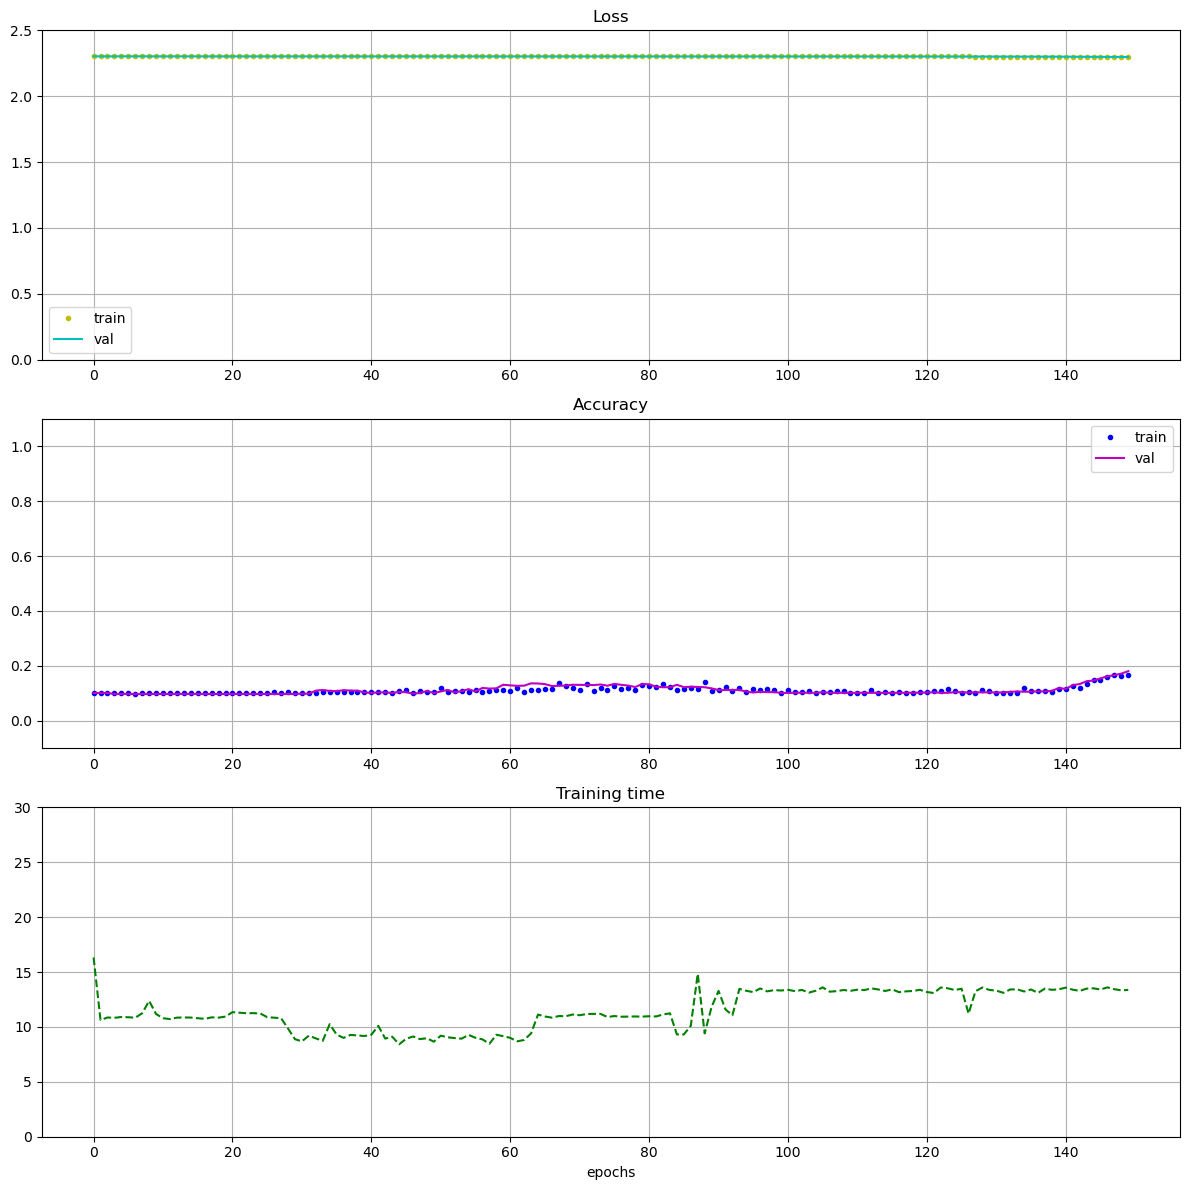

In [52]:
plot_train_stats(*trainer_A.get_loss_acc_time_history(), fig_id='model_stats_a')

In [29]:
trainer_A.model(example_image.unsqueeze(0).to('cuda'))

tensor([[0.1261, 0.0873, 0.0737, 0.0975, 0.0899, 0.1009, 0.1108, 0.0777, 0.1195,
         0.1166]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [30]:
example_label

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

# What? NETWORK is evolving!

8. Zwiększ liczbę filtrów wykorzystywanych w obu warstwach konwolucyjnych z 5 do 20.
    1. Jak zmieniła się liczba parametrów modelu?
    2. Jak zmienił się czas trenowania?
    3. Jak zmieniły się rezultaty treningu? [📈] [🕒]
9. Sekwencja `konwolucja` $\rightarrow$ ` konwolucja` $\rightarrow$ `pooling` tworzy tzw. blok konwolucyjny. Wielokrotna aplikacja takiego bloku stopniowo przetwarza obraz (dane mocno zależne od lokalizacji i struktury) w wektor cech (niezależnych od siebie).
    1. Zmień rozmiar okna poolingu z 8x8 na 2x2.
    2. Przygotuj funkcję, które dla zadanych parametrów zwraca cały taki blok - wykorzystamy ją by wielokrotnie umieszczać w potoku przetwarzania sekwencję konwolucja->konwolucja->pooling (wyjście z jednego bloku stanowi wejście do kolejnego). [⌨️]
        1. Niech parametrem bloku będzie liczba filtrów wykorzystywanych w warstwach konwolucyjnych.
    3. Zmodyfikuj model tak, by korzystał z dwóch bloków - w pierwszym jest po 20 filtrów w warstwie, w drugim po 40. [⌨️]
        1. Uruchom kilka-kilkanaście epok treningu takiej sieci. Czy efekty wyglądają obiecująco?
        2. Zamień aktywacje we wszystkich warstwach (poza ostatnią) na aktywację ReLU. [⌨️]
            1. Powinno to przyśpieszyć trening - pochodna ReLU jest niezerowa w znacznie szerszym zakresie argumentów niż pochodna sigmoidy. 
            2. To szczególnie istotne przy głębszych sieciach (a taką będziemy trenować).
        3. Wytrenuj dwublokowy model - jak teraz wyglądają rezultaty? [📈] [🕒]
    4. Dodaj jeszcze dwa bloki - teraz będzie ich łącznie cztery. Liczby filtrów to kolejno 20, 40, 80, 160.
        1. A teraz? Jak przebiega trening, jakie sieć osiąga wyniki? [📈] [🕒]
    10. Dodamy teraz kilka usprawnień. Części z nich nie omawialiśmy jeszcze na zajęciach - będą poruszone za tydzień. Na szczęście nie przeszkadza to w korzystaniu z ich gotowych implementacji.
        1. Po każdej warstwie konwolucyjnej (a przed następną warstwą) umieść warstwę batch normalisation. [⌨️]
            1. Stabilizuje ona wynikowy rozkład wartości, ułatwiając uczenie się kolejnych warstw.
        2. Jak teraz przebiegało uczenie? [📈] [🕒]
    11. Na koniec trzeba zadbać o to, by nasza sieć nie skupiała się na dopasowaniu do danych treningowych - a zamiast tego próbowała być nieco bardziej uniwersalna.
        1. Po każdej warstwie poolingowej (a przed wyjściem z bloku) umieść warstwę dropout. [⌨️]
        2. Warstwa ta w czasie treningu "ukrywa" losowo wybrane wartości, uniemożliwiając korzystanie z nich dalszym warstwom. Dzięki temu nie mogą one "nauczyć się" korzystania tylko z małej i specyficznej części danych - będą musiały być bardziej "elastyczne".
        3. Procent ukrywanych wartości jest parametrem takiej warstwy - a więc i całego naszego bloku. Zastosuj następującą sekwencję dropout rates: 0.1, 0.2, 0.3, 0.4 (na początku niskie, by nie tracić za wiele informacji, potem stopniowo coraz większe).
        4. Kolejny raz zbadaj proces uczenia. [📈] [🕒]

`Model B`

In [25]:
class CNNModelB(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, padding='same'),
            nn.Sigmoid(),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, padding='same'),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=8),
            nn.Flatten(),
            nn.Linear(in_features=20*4*4, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor):
        probs = self.sequence(x)
        return probs

In [26]:
trainer_B = Trainer(
    model=CNNModelB(),
    train_ds=full_train_ds,
    val_ds=full_val_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 150

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_B.train_step()
    avg_val_loss, avg_val_acc = trainer_B.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.100 loss: 2.303 train_time: 14.97 s
Val | acc: 0.101 loss: 2.303
================ epoch 010 ================
Train | acc: 0.103 loss: 2.303 train_time: 14.86 s
Val | acc: 0.098 loss: 2.303
================ epoch 020 ================
Train | acc: 0.102 loss: 2.303 train_time: 10.06 s
Val | acc: 0.097 loss: 2.303
================ epoch 030 ================
Train | acc: 0.099 loss: 2.303 train_time: 10.67 s
Val | acc: 0.098 loss: 2.303
================ epoch 040 ================
Train | acc: 0.108 loss: 2.302 train_time: 10.75 s
Val | acc: 0.098 loss: 2.302
================ epoch 050 ================
Train | acc: 0.105 loss: 2.302 train_time: 10.85 s
Val | acc: 0.098 loss: 2.302
================ epoch 060 ================
Train | acc: 0.111 loss: 2.302 train_time: 10.37 s
Val | acc: 0.101 loss: 2.302
================ epoch 070 ================
Train | acc: 0.121 loss: 2.302 train_time: 10.35 s
Val | acc: 0.123 loss: 2.302
========

Saving figure model_stats_b


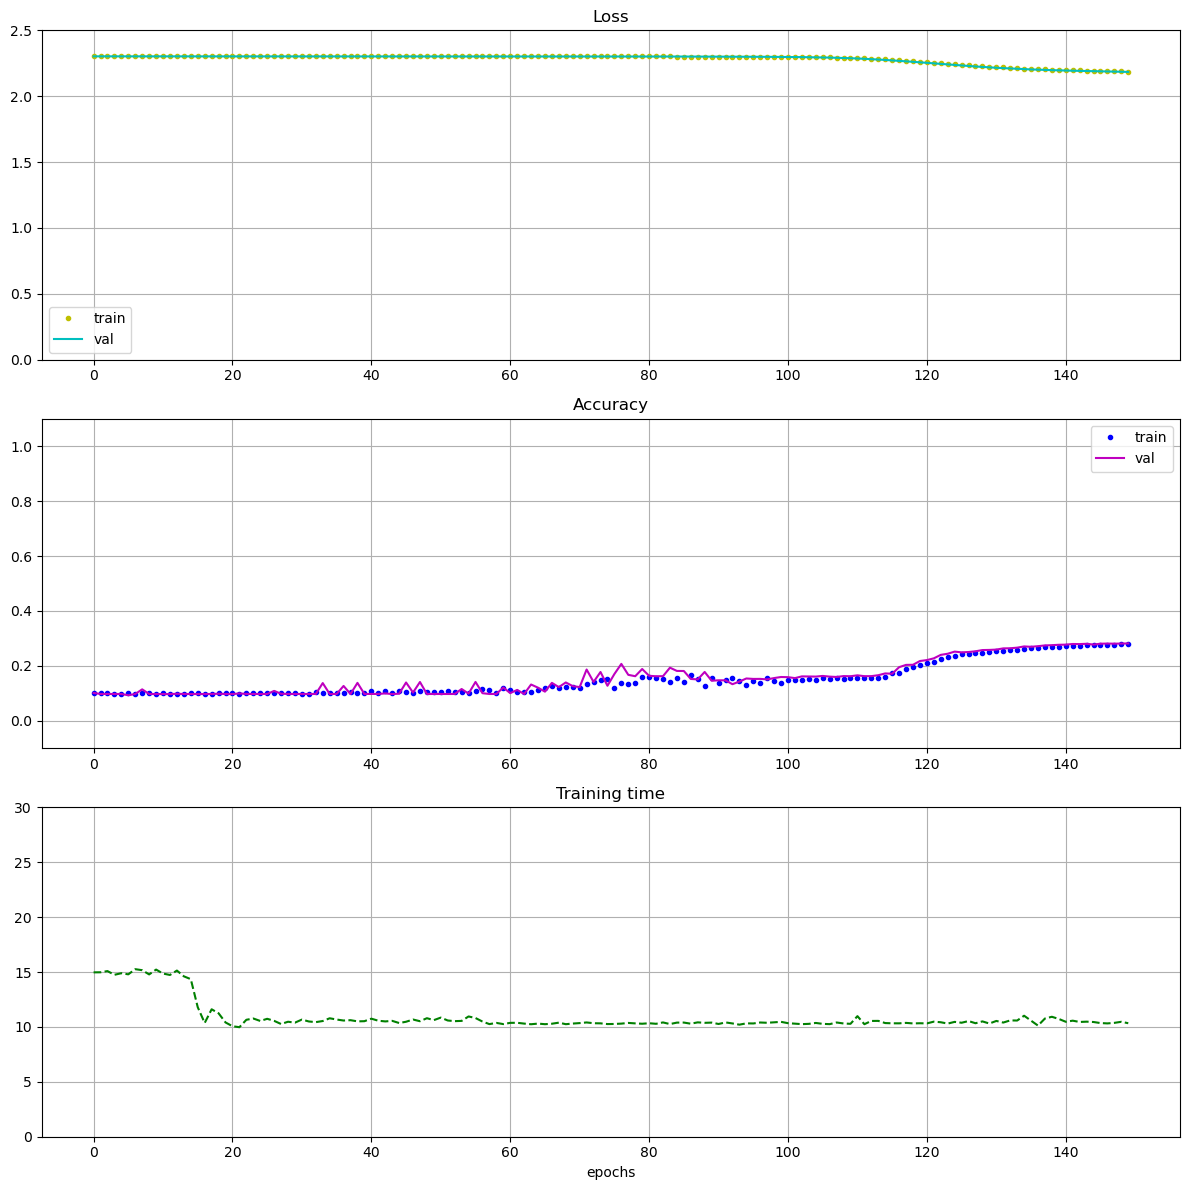

In [53]:
plot_train_stats(*trainer_B.get_loss_acc_time_history(), fig_id='model_stats_b')

In [31]:
trainer_B.model(example_image.unsqueeze(0).to('cuda'))

tensor([[3.2506e-04, 1.4089e-04, 2.6314e-04, 6.2045e-04, 3.1079e-02, 9.1049e-01,
         3.9574e-02, 6.1159e-04, 6.8423e-04, 1.6215e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [32]:
example_label

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Convolution block function

In [8]:
from torch import nn
from typing import Literal, Union

def get_conv_block(
    in_ch: int, mid_ch: int, out_ch: int, 
    kernel_a_size: int = 3, kernel_b_size: int = 3, 
    pool_size: int = 2, activation_func_str: Literal['relu', 'sigmoid'] = 'relu',
    batch_norm: bool = False,
    dropout_rate: Union[float, None] = None):
    
    if activation_func_str == 'relu':
        activation_func = nn.ReLU
    elif activation_func_str == 'sigmoid':
        activation_func = nn.Sigmoid
    else:
        raise ValueError("No such activation func to choose.")
        
    seq_conv_1 = [
        nn.Conv2d(
            in_channels=in_ch, out_channels=mid_ch, 
            kernel_size=kernel_a_size, stride=1, padding='same'),
        activation_func()
    ]
    
    seq_conv_2 = [
        nn.Conv2d(
            in_channels=mid_ch, out_channels=out_ch, 
            kernel_size=kernel_b_size, stride=1, padding='same'),
        activation_func()
    ]
    
    if batch_norm:
        seq_conv_1.append(nn.BatchNorm2d(num_features=mid_ch))
        seq_conv_2.append(nn.BatchNorm2d(num_features=out_ch))
    
    seq_max_pool = [
        nn.MaxPool2d(kernel_size=pool_size)
    ]
    
    if dropout_rate is not None:
        seq_max_pool.append(nn.Dropout(p=dropout_rate))
    
    return nn.Sequential(*seq_conv_1, *seq_conv_2, *seq_max_pool)

`Model C`

In [49]:
class CNNModelC(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            get_conv_block(in_ch=3, mid_ch=20, out_ch=20, activation_func_str='sigmoid'),
            get_conv_block(in_ch=20, mid_ch=40, out_ch=40, activation_func_str='sigmoid'),
            nn.Flatten(),
            nn.Linear(in_features=40*(32 // 4)**2, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor):
        probs = self.sequence(x)
        return probs

In [50]:
trainer_C = Trainer(
    model=CNNModelC(),
    train_ds=full_train_ds,
    val_ds=full_val_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 16

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_C.train_step()
    avg_val_loss, avg_val_acc = trainer_C.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.098 loss: 2.303 train_time: 12.53 s
Val | acc: 0.098 loss: 2.303
================ epoch 010 ================
Train | acc: 0.096 loss: 2.303 train_time: 12.85 s
Val | acc: 0.098 loss: 2.303
================ training ended ================
Train | acc: 0.097 loss: 2.303 train_time: 12.05 s
Val | acc: 0.102 loss: 2.303


Saving figure model_stats_c


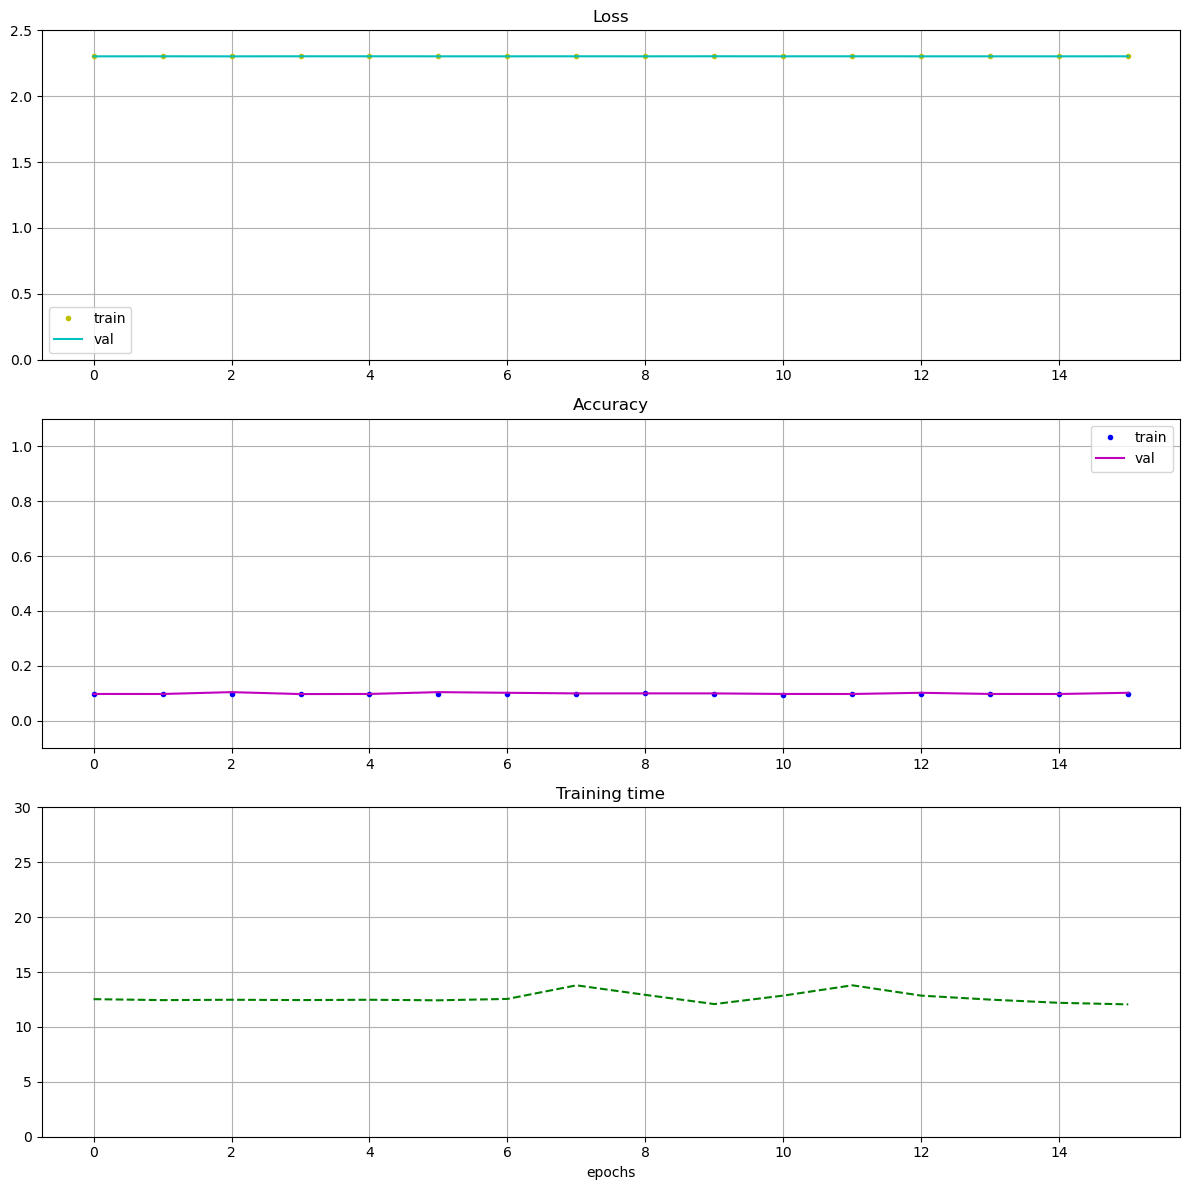

In [54]:
plot_train_stats(*trainer_C.get_loss_acc_time_history(), fig_id='model_stats_c')

In [ ]:
# wyniki wyglądają obiecująco ???

# Raczej nie, ale też nie wiemy czy później by nie skoczyło ze względu na mały learning rate

`Model D`

In [57]:
class CNNModelD(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            get_conv_block(in_ch=3, mid_ch=20, out_ch=20, activation_func_str='relu'),
            get_conv_block(in_ch=20, mid_ch=40, out_ch=40, activation_func_str='relu'),
            nn.Flatten(),
            nn.Linear(in_features=40*(32 // 4)**2, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor):
        probs = self.sequence(x)
        return probs

In [58]:
trainer_D = Trainer(
    model=CNNModelD(),
    train_ds=full_train_ds,
    val_ds=full_val_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 120

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_D.train_step()
    avg_val_loss, avg_val_acc = trainer_D.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.105 loss: 2.302 train_time: 12.44 s
Val | acc: 0.105 loss: 2.302
================ epoch 010 ================
Train | acc: 0.308 loss: 2.149 train_time: 12.26 s
Val | acc: 0.319 loss: 2.135
================ epoch 020 ================
Train | acc: 0.388 loss: 2.069 train_time: 12.52 s
Val | acc: 0.378 loss: 2.080
================ epoch 030 ================
Train | acc: 0.475 loss: 1.983 train_time: 12.47 s
Val | acc: 0.456 loss: 2.005
================ epoch 040 ================
Train | acc: 0.510 loss: 1.950 train_time: 12.34 s
Val | acc: 0.474 loss: 1.982
================ epoch 050 ================
Train | acc: 0.541 loss: 1.920 train_time: 12.64 s
Val | acc: 0.502 loss: 1.955
================ epoch 060 ================
Train | acc: 0.572 loss: 1.890 train_time: 12.35 s
Val | acc: 0.523 loss: 1.933
================ epoch 070 ================
Train | acc: 0.597 loss: 1.865 train_time: 12.30 s
Val | acc: 0.533 loss: 1.922
========

Saving figure model_stats_d


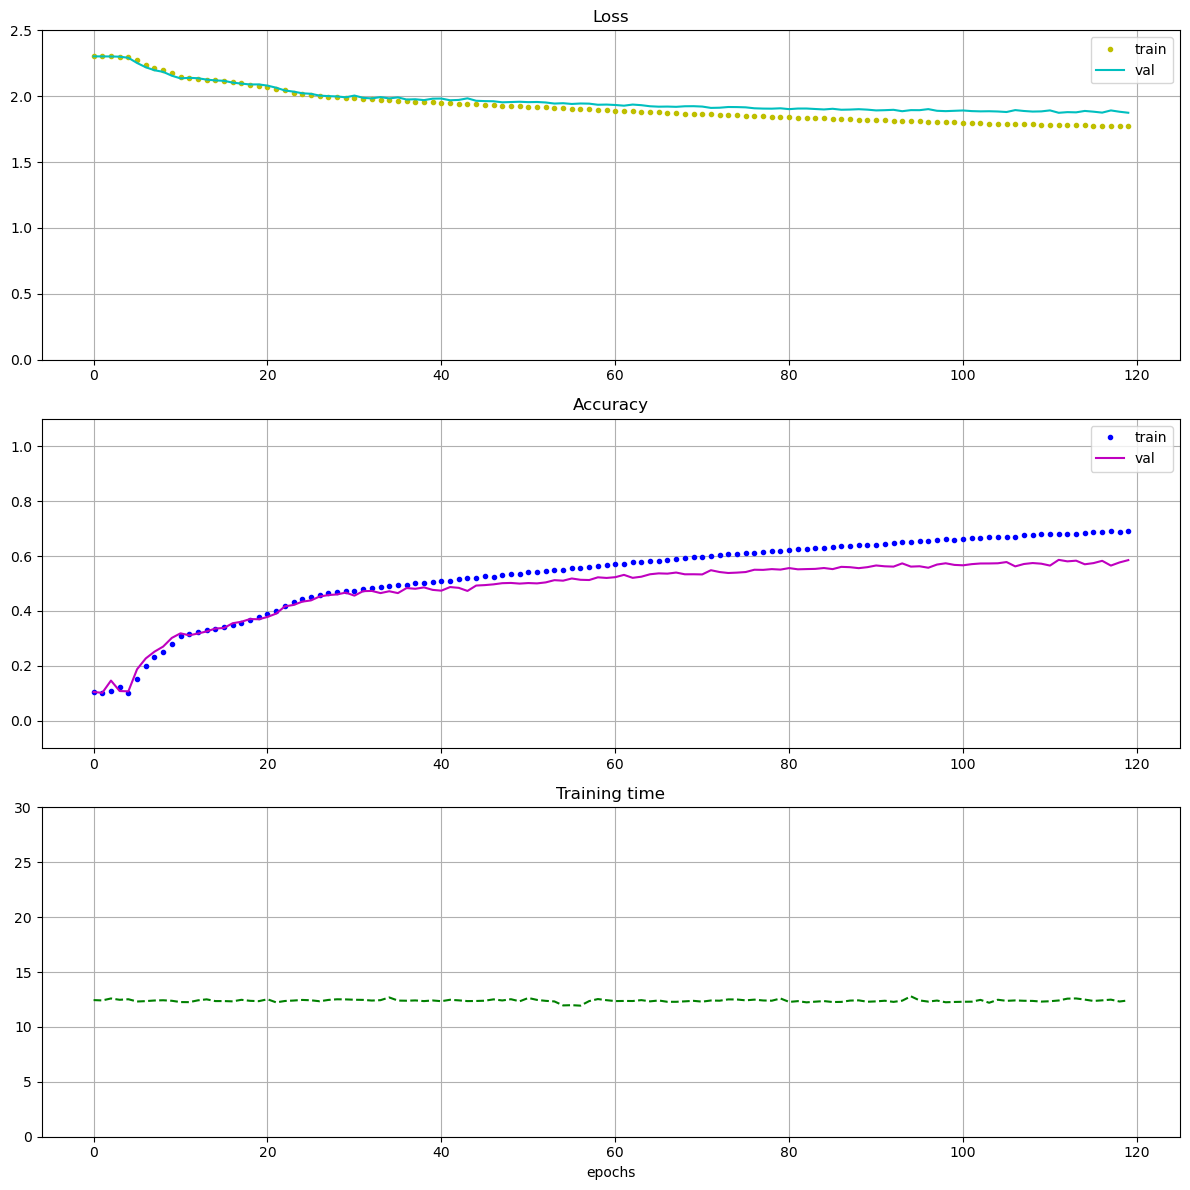

In [59]:
plot_train_stats(*trainer_D.get_loss_acc_time_history(), fig_id='model_stats_d')

`Model E`

In [63]:
class CNNModelE(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            get_conv_block(in_ch=3, mid_ch=20, out_ch=20, activation_func_str='relu'),
            get_conv_block(in_ch=20, mid_ch=40, out_ch=40, activation_func_str='relu'),
            get_conv_block(in_ch=40, mid_ch=80, out_ch=80, activation_func_str='relu'),
            get_conv_block(in_ch=80, mid_ch=160, out_ch=160, activation_func_str='relu'),
            nn.Flatten(),
            nn.Linear(in_features=160*(32 // 16)**2, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor):
        probs = self.sequence(x)
        return probs

In [64]:
trainer_E = Trainer(
    model=CNNModelE(),
    train_ds=full_train_ds,
    val_ds=full_val_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 120

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_E.train_step()
    avg_val_loss, avg_val_acc = trainer_E.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.100 loss: 2.303 train_time: 13.27 s
Val | acc: 0.101 loss: 2.303
================ epoch 010 ================
Train | acc: 0.100 loss: 2.303 train_time: 12.84 s
Val | acc: 0.101 loss: 2.303
================ epoch 020 ================
Train | acc: 0.100 loss: 2.303 train_time: 12.78 s
Val | acc: 0.101 loss: 2.303
================ epoch 030 ================
Train | acc: 0.100 loss: 2.303 train_time: 13.88 s
Val | acc: 0.101 loss: 2.303
================ epoch 040 ================
Train | acc: 0.100 loss: 2.303 train_time: 12.82 s
Val | acc: 0.098 loss: 2.303
================ epoch 050 ================
Train | acc: 0.100 loss: 2.303 train_time: 14.11 s
Val | acc: 0.098 loss: 2.303
================ epoch 060 ================
Train | acc: 0.100 loss: 2.303 train_time: 13.33 s
Val | acc: 0.098 loss: 2.303
================ epoch 070 ================
Train | acc: 0.100 loss: 2.303 train_time: 13.15 s
Val | acc: 0.098 loss: 2.303
========

Saving figure model_stats_e


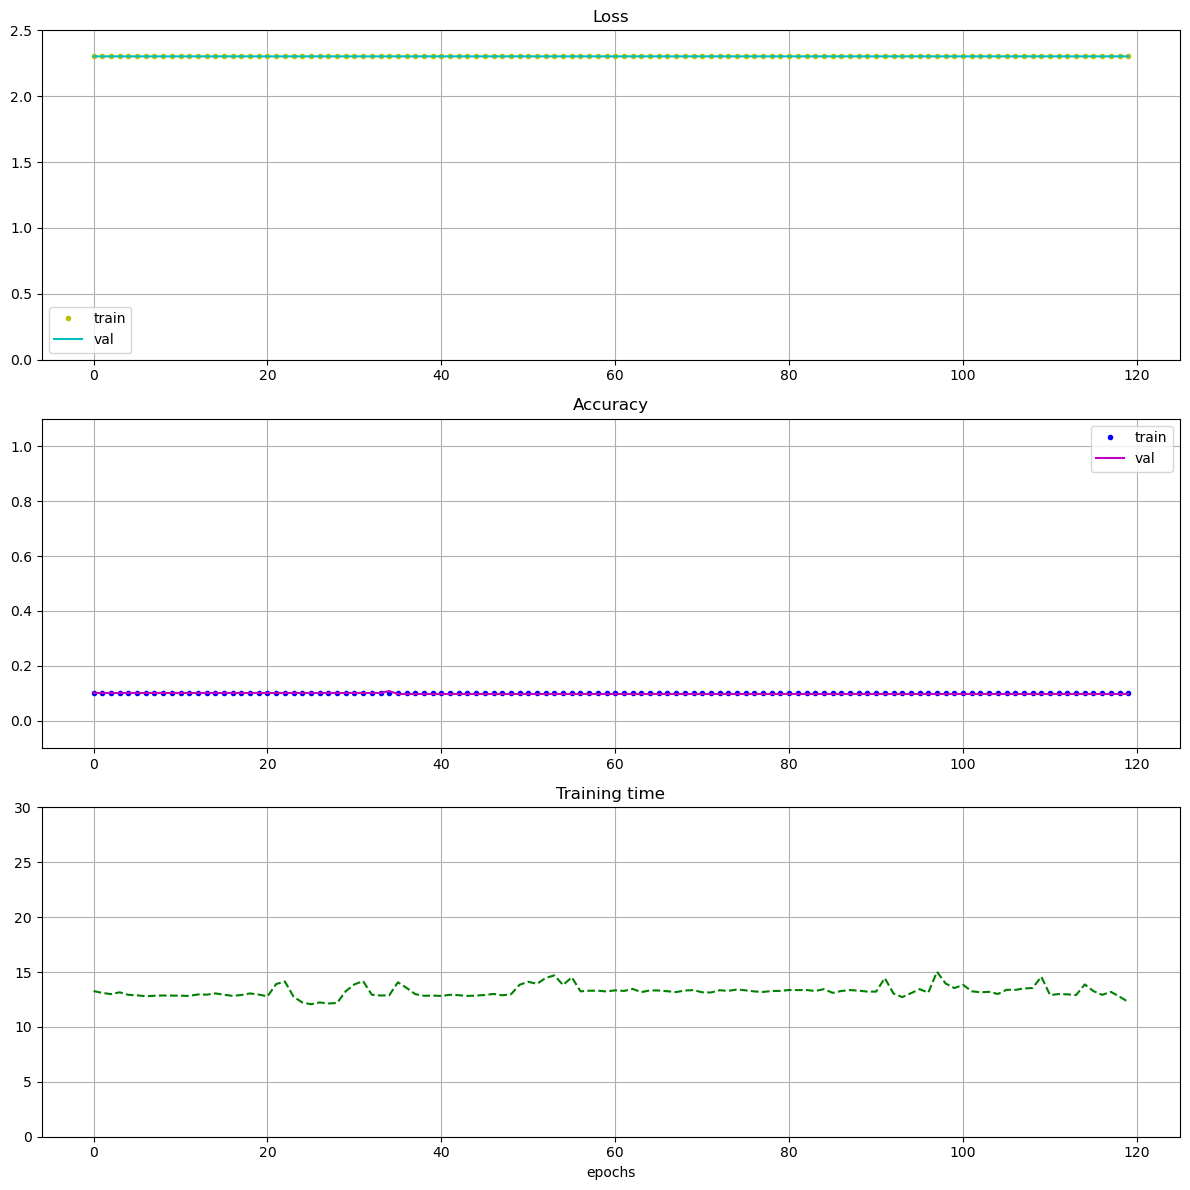

In [65]:
plot_train_stats(*trainer_E.get_loss_acc_time_history(), fig_id='model_stats_e')

`Model F`

In [66]:
class CNNModelF(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            get_conv_block(in_ch=3, mid_ch=20, out_ch=20, batch_norm=True),
            get_conv_block(in_ch=20, mid_ch=40, out_ch=40, batch_norm=True),
            get_conv_block(in_ch=40, mid_ch=80, out_ch=80, batch_norm=True),
            get_conv_block(in_ch=80, mid_ch=160, out_ch=160, batch_norm=True),
            nn.Flatten(),
            nn.Linear(in_features=160*(32 // 16)**2, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor):
        probs = self.sequence(x)
        return probs

In [67]:
trainer_F = Trainer(
    model=CNNModelF(),
    train_ds=full_train_ds,
    val_ds=full_val_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 120

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_F.train_step()
    avg_val_loss, avg_val_acc = trainer_F.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.407 loss: 2.062 train_time: 13.51 s
Val | acc: 0.493 loss: 1.975
================ epoch 010 ================
Train | acc: 0.859 loss: 1.617 train_time: 16.01 s
Val | acc: 0.738 loss: 1.729
================ epoch 020 ================
Train | acc: 0.942 loss: 1.526 train_time: 13.65 s
Val | acc: 0.750 loss: 1.715
================ epoch 030 ================
Train | acc: 0.960 loss: 1.502 train_time: 16.00 s
Val | acc: 0.757 loss: 1.706
================ epoch 040 ================
Train | acc: 0.966 loss: 1.496 train_time: 15.83 s
Val | acc: 0.755 loss: 1.708
================ epoch 050 ================
Train | acc: 0.969 loss: 1.492 train_time: 15.96 s
Val | acc: 0.752 loss: 1.710
================ epoch 060 ================
Train | acc: 0.972 loss: 1.490 train_time: 16.02 s
Val | acc: 0.752 loss: 1.709
================ epoch 070 ================
Train | acc: 0.974 loss: 1.487 train_time: 15.83 s
Val | acc: 0.750 loss: 1.712
========

Saving figure model_stats_f


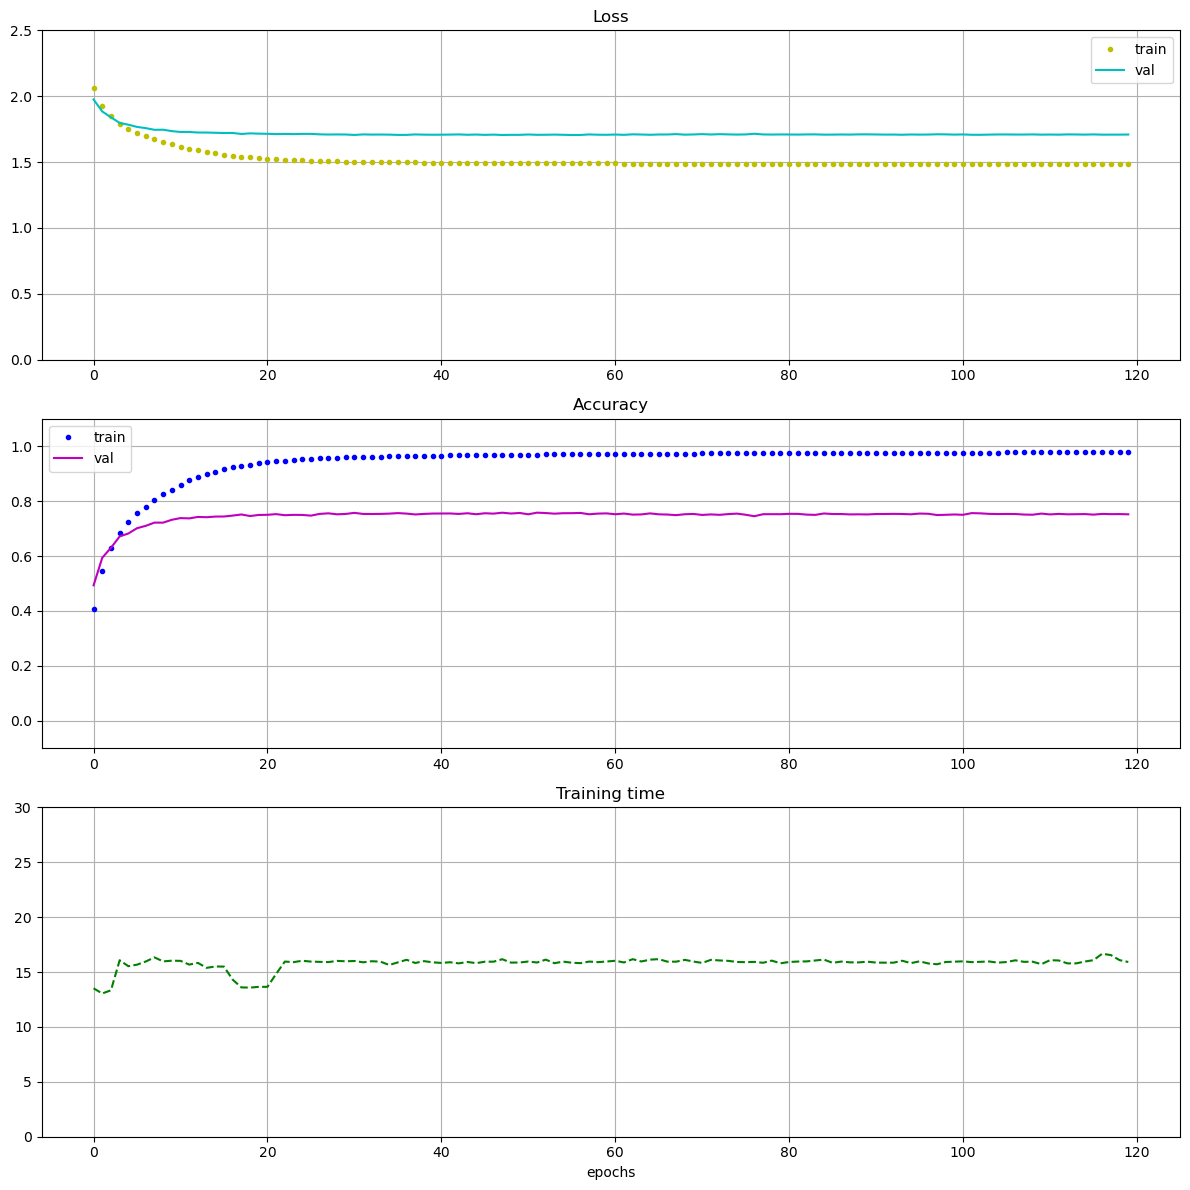

In [68]:
plot_train_stats(*trainer_F.get_loss_acc_time_history(), fig_id='model_stats_f')

`Model G`

In [10]:
import torch

class CNNModelG(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            get_conv_block(in_ch=3, mid_ch=20, out_ch=20, batch_norm=True, dropout_rate=0.1),
            get_conv_block(in_ch=20, mid_ch=40, out_ch=40, batch_norm=True, dropout_rate=0.2),
            get_conv_block(in_ch=40, mid_ch=80, out_ch=80, batch_norm=True, dropout_rate=0.3),
            get_conv_block(in_ch=80, mid_ch=160, out_ch=160, batch_norm=True, dropout_rate=0.4),
            nn.Flatten(),
            nn.Linear(in_features=160*(32 // 16)**2, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor):
        probs = self.sequence(x)
        return probs

In [16]:
trainer_G = Trainer(
    model=CNNModelG(),
    train_ds=full_train_ds,
    val_ds=full_val_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 150

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_G.train_step()
    avg_val_loss, avg_val_acc = trainer_G.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.313 loss: 2.144 train_time: 18.29 s
Val | acc: 0.382 loss: 2.076
================ epoch 010 ================
Train | acc: 0.652 loss: 1.812 train_time: 13.77 s
Val | acc: 0.635 loss: 1.826
================ epoch 020 ================
Train | acc: 0.748 loss: 1.715 train_time: 13.81 s
Val | acc: 0.747 loss: 1.718
================ epoch 030 ================
Train | acc: 0.789 loss: 1.674 train_time: 13.82 s
Val | acc: 0.778 loss: 1.684
================ epoch 040 ================
Train | acc: 0.816 loss: 1.647 train_time: 13.70 s
Val | acc: 0.803 loss: 1.660
================ epoch 050 ================
Train | acc: 0.839 loss: 1.624 train_time: 13.78 s
Val | acc: 0.808 loss: 1.652
================ epoch 060 ================
Train | acc: 0.851 loss: 1.612 train_time: 13.78 s
Val | acc: 0.817 loss: 1.644
================ epoch 070 ================
Train | acc: 0.865 loss: 1.598 train_time: 13.71 s
Val | acc: 0.819 loss: 1.642
========

Saving figure model_stats_g


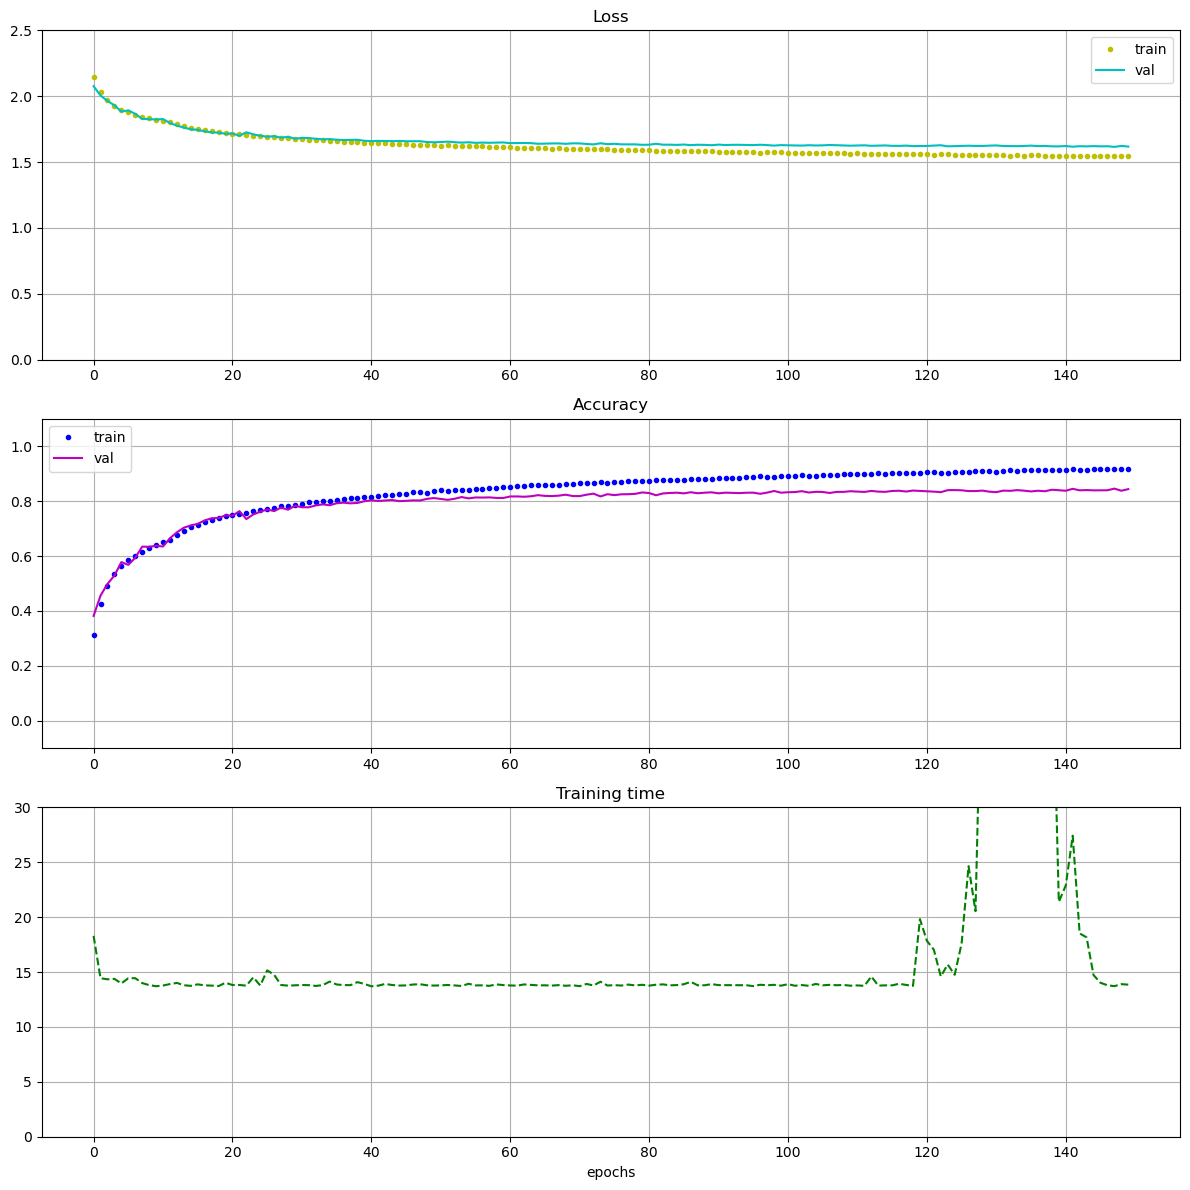

In [19]:
plot_train_stats(*trainer_G.get_loss_acc_time_history(), fig_id='model_stats_g')

In [21]:
torch.save(trainer_G.model.state_dict(), 'model_G_150_sd.pt')

# Mind the GAP !

(to już ostatnia sekcja - ale na tym etapie masz prawo odczuwać zmęczenie tematem! - przejdź się na spacer, zdrzemnij, albo chociaż napij herbaty) 

12. Zostaje jeszcze sprawa obsługi fotografii o nietypowych wymiarach. W tym celu wykorzystamy operację Global Average Pooling (GAP). 
    1. Zmodyfikuj definicję wejścia do sieci tak, by przyjmowała obrazy o dowolnym rozmiarze. [⌨️]
    2. Ostatnią z użytych warstw typu max pooling zamień na warstwę typu GAP. [⌨️]
    3. Ostatni już raz - zweryfikuj przebieg procesu uczenia. Uwaga! Postaraj się zapisać znalezione na koniec parametry modelu (większość bibliotek pozwala na jego bezpośrednie zapisywanie) - przydadzą się za chwilę. [📈] [🕒]
13. Przygotuj nowy obraz zawierający obiekt należący do jednej z 10 rozpoznawanych klas - ale taki, który nie jest kwadratowy. Przeskaluj go do podobnego rozmiaru jak obrazy używane do treningu - ale z zachowaniem jego własnych proporcji (czyli np. 28x32 albo 36x30 - zgadza się rząd wielkości, ale nie jest to 32x32). Czy w tym przypadku sieć również poprawnie rozpozna zawartość zdjęcia?
14. Przejrzyj wszystkie uzyskane wyniki (jest ich sporo na tym etapie). Co o nich myślisz? Jakie możesz wyciągnąć wnioski na temat stosowanych architektur?

`Model GAP`

In [20]:
from torch.nn import functional as F

In [124]:
def global_average_pool(t: torch.Tensor) -> torch.Tensor:
    out_tensor = torch.empty((t.shape[0], t.shape[1], 1, 1))
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            out_tensor[i, j] = t[i, j].mean()
    return out_tensor

In [29]:
from torch.nn import functional as F

class CNNModelGAP(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            get_conv_block(in_ch=3, mid_ch=20, out_ch=20, batch_norm=True, dropout_rate=0.1),
            get_conv_block(in_ch=20, mid_ch=40, out_ch=40, batch_norm=True, dropout_rate=0.2),
            get_conv_block(in_ch=40, mid_ch=80, out_ch=80, batch_norm=True, dropout_rate=0.3),
            
            nn.Conv2d(
                in_channels=80, out_channels=160, 
                kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=160),
            nn.Conv2d(
                in_channels=160, out_channels=160, 
                kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=160),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # GAP
            nn.Dropout(p=0.4),
            
            nn.Flatten(),
            nn.Linear(in_features=160, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        probs = self.sequence(x)
        return probs

In [30]:
trainer_GAP = Trainer(
    model=CNNModelGAP().to('cuda'),
    train_ds=full_train_ds,
    val_ds=full_val_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 120

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_GAP.train_step()
    avg_val_loss, avg_val_acc = trainer_GAP.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.226 loss: 2.242 train_time: 14.44 s
Val | acc: 0.274 loss: 2.175
================ epoch 010 ================
Train | acc: 0.636 loss: 1.834 train_time: 16.49 s
Val | acc: 0.637 loss: 1.827
================ epoch 020 ================
Train | acc: 0.723 loss: 1.746 train_time: 14.50 s
Val | acc: 0.726 loss: 1.736
================ epoch 030 ================
Train | acc: 0.769 loss: 1.699 train_time: 16.68 s
Val | acc: 0.768 loss: 1.695
================ epoch 040 ================
Train | acc: 0.795 loss: 1.671 train_time: 14.24 s
Val | acc: 0.793 loss: 1.669
================ epoch 050 ================
Train | acc: 0.818 loss: 1.648 train_time: 13.62 s
Val | acc: 0.795 loss: 1.667
================ epoch 060 ================
Train | acc: 0.832 loss: 1.634 train_time: 13.62 s
Val | acc: 0.815 loss: 1.647
================ epoch 070 ================
Train | acc: 0.846 loss: 1.620 train_time: 13.79 s
Val | acc: 0.820 loss: 1.643
========

Saving figure model_stats_gap


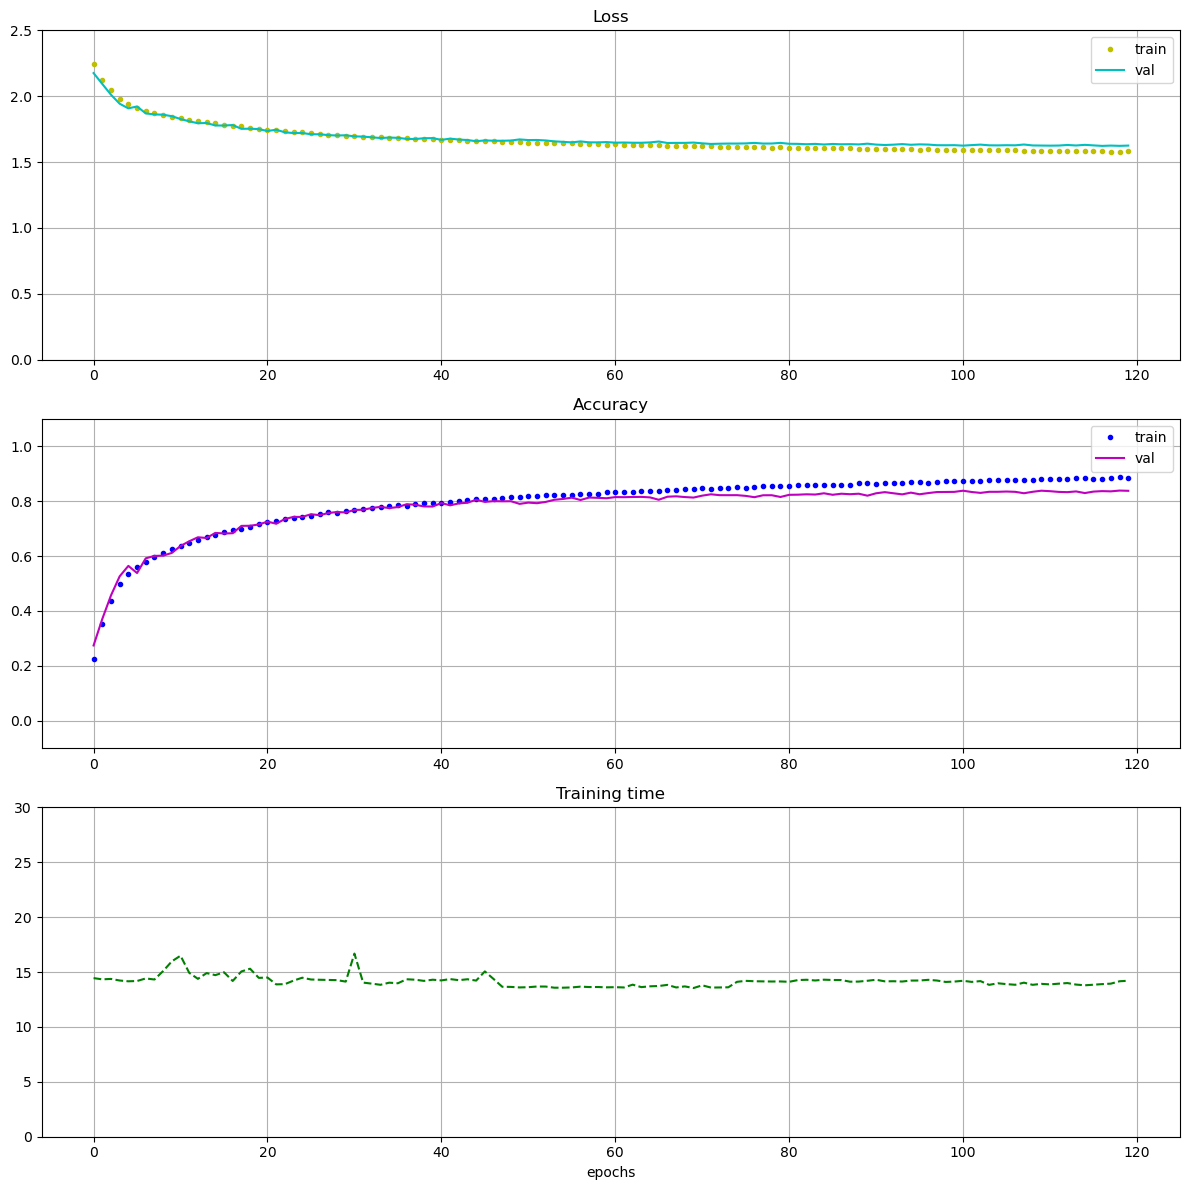

In [31]:
plot_train_stats(*trainer_GAP.get_loss_acc_time_history(), fig_id='model_stats_gap')

Next `120` epochs...

In [111]:
n_epochs = 120

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_GAP.train_step()
    avg_val_loss, avg_val_acc = trainer_GAP.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i+n_epochs:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 120 ================
Train | acc: 0.886 loss: 1.578 train_time: 16.53 s
Val | acc: 0.843 loss: 1.621
================ epoch 130 ================
Train | acc: 0.890 loss: 1.575 train_time: 14.22 s
Val | acc: 0.840 loss: 1.621
================ epoch 140 ================
Train | acc: 0.897 loss: 1.567 train_time: 14.43 s
Val | acc: 0.843 loss: 1.619
================ epoch 150 ================
Train | acc: 0.900 loss: 1.564 train_time: 16.46 s
Val | acc: 0.845 loss: 1.618
================ epoch 160 ================
Train | acc: 0.904 loss: 1.561 train_time: 16.26 s
Val | acc: 0.840 loss: 1.621
================ epoch 170 ================
Train | acc: 0.907 loss: 1.557 train_time: 16.59 s
Val | acc: 0.847 loss: 1.615
================ epoch 180 ================
Train | acc: 0.912 loss: 1.552 train_time: 16.32 s
Val | acc: 0.847 loss: 1.614
================ epoch 190 ================
Train | acc: 0.915 loss: 1.549 train_time: 16.37 s
Val | acc: 0.846 loss: 1.614
========

Saving figure model_stats_gap_240


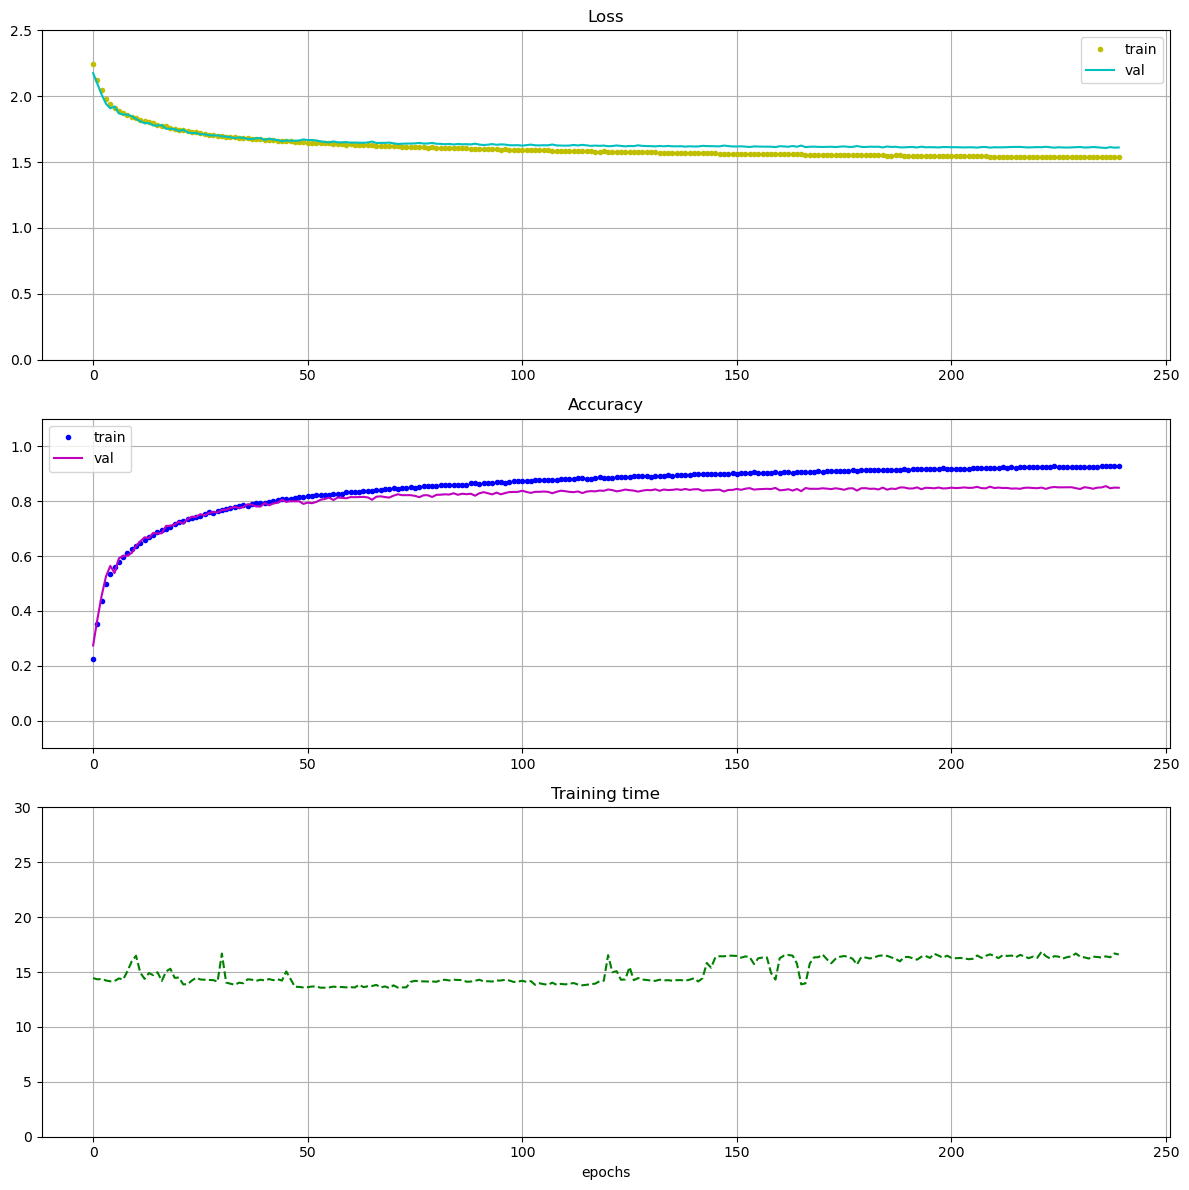

In [112]:
plot_train_stats(*trainer_GAP.get_loss_acc_time_history(), fig_id='model_stats_gap_240')

Testowanie

In [36]:
from torchvision.io import read_image

In [57]:
cat_tensor = read_image('cat.png') / 255.

Saving figure cat_image


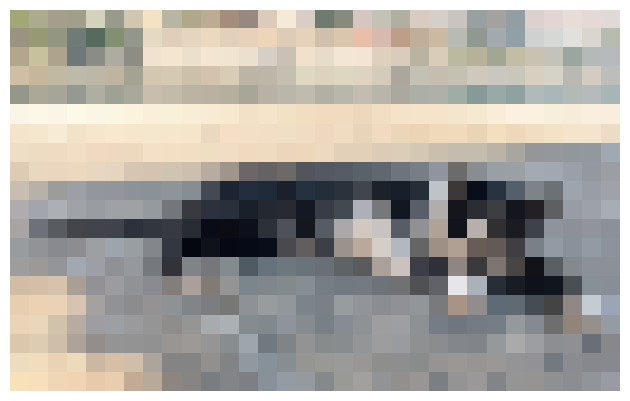

In [93]:
plot_image(cat_tensor, fig_id='cat_image', save=True)

In [105]:
frog_tensor = read_image('frog.png')[:3] / 255.

In [106]:
frog_tensor.shape

torch.Size([3, 18, 32])

Saving figure frog_image


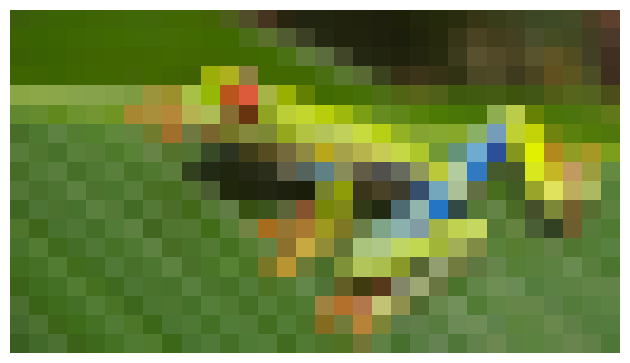

In [107]:
plot_image(frog_tensor, fig_id='frog_image', save=True)

In [108]:
def get_acc_loss(model: nn.Module, test_ds: Dataset, batch_size=64) -> tuple[float, float]:
    test_data_loader = DataLoader(test_ds, batch_size=batch_size,
                                  shuffle=True, drop_last=True)
    num_batches = len(test_data_loader)
    epoch_loss = 0.
    epoch_correct_preds = 0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    loss_function = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(test_data_loader):
            X, y = X.float().to(device), y.float().to(device)
            prediction = model(X)
            assert prediction.shape == y.shape, "prediction and y shapes does not match"
            loss = loss_function(prediction, y)
            epoch_loss += loss.item()
            correct_preds = (prediction.argmax(dim=1) == y.argmax(dim=1)).count_nonzero().item()
            epoch_correct_preds += correct_preds

        epoch_avg_loss = epoch_loss / num_batches
        epoch_avg_acc = epoch_correct_preds / (num_batches * batch_size)

        return epoch_avg_acc, epoch_avg_loss

In [77]:
model_G_acc, model_G_avg_loss = get_acc_loss(trainer_G.model, cifar_test_ds)
print("Model acc: ", model_G_acc)
print("Model loss: ", model_G_avg_loss)

Model acc:  0.8363381410256411
Model loss:  1.6246747030661657


In [78]:
model_F_acc, model_F_avg_loss = get_acc_loss(trainer_F.model, cifar_test_ds)
print("Model acc: ", model_F_acc)
print("Model loss: ", model_F_avg_loss)

Model acc:  0.7589142628205128
Model loss:  1.7030209379318433


`120` epochs:

In [35]:
model_GAP_acc, model_GAP_avg_loss = get_acc_loss(trainer_GAP.model, cifar_test_ds)
print("Model acc: ", model_GAP_acc)
print("Model loss: ", model_GAP_avg_loss)

Model acc:  0.8313301282051282
Model loss:  1.6304343082965949


In [114]:
with torch.no_grad():
    label = trainer_GAP.model(frog_tensor.unsqueeze(0).to('cuda')).to('cpu').squeeze()
label

tensor([6.5087e-07, 3.1404e-05, 1.6617e-09, 6.0419e-08, 8.9338e-09, 4.1257e-09,
        9.9997e-01, 1.5769e-09, 9.3848e-09, 2.0747e-06])

In [110]:
print(int_class_dict[6], f'{label[6].item():.3}')
print(int_class_dict[1], f'{label[1].item():.3}')

frog 0.999
automobile 0.00048


In [115]:
# after full training
print(int_class_dict[6], f'{label[6].item():.3}')
print(int_class_dict[1], f'{label[1].item():.3}')

frog 1.0
automobile 3.14e-05


`240` epochs:

In [116]:
model_GAP_acc, model_GAP_avg_loss = get_acc_loss(trainer_GAP.model, cifar_test_ds)
print("Model acc: ", model_GAP_acc)
print("Model loss: ", model_GAP_avg_loss)

Model acc:  0.8442508012820513
Model loss:  1.6176675657431285


In [120]:
with torch.no_grad():
    label = trainer_GAP.model(cat_tensor.unsqueeze(0).to('cuda')).to('cpu').squeeze()
label

tensor([9.7283e-01, 2.2260e-06, 5.2534e-05, 2.6576e-02, 1.1816e-09, 5.2483e-07,
        3.8656e-05, 1.5159e-07, 1.1259e-06, 4.9648e-04])

In [119]:
print(int_class_dict[0], f'{label[0].item():.3}')
print(int_class_dict[3], f'{label[3].item():.3}')

airplane 0.973
cat 0.0266
